In [1]:
import pandas as pd
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from umap import UMAP

from sklearn.metrics import roc_auc_score
from pandarallel import pandarallel

import seaborn as sns
sns.set(style = 'white', font_scale=1.5)
pandarallel.initialize(nb_workers = 8, progress_bar=True) # initialize(36) or initialize(os.cpu_count()-1)

/home/was966/micromamba/envs/RNA/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/was966/micromamba/envs/RNA/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/was966/micromamba/envs/RNA/lib/python3.11/site-packages/umap/distanc

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
import sys
sys.path.insert(0, '/home/was966/Research/PSOG/')
from gdd.correlation import pairwise_correlation
from gdd.combination import pairwise_combination
from gdd.score import Xy_score
from gdd.plot import plot_batch
BEST = ['PIK3CD', 'TOLLIP']

In [3]:
data_path = '/n/data1/hms/dbmi/zitnik/lab/users/was966/ITRP/TCGA-ITRP-MERGE/735'

tcga_tpm = pd.read_pickle(os.path.join(data_path, 'TPM.TCGA.TABLE'))
itrp_tpm = pd.read_pickle(os.path.join(data_path, 'TPM.ITRP.TABLE'))
itrp_tpm_crt = pd.read_pickle(os.path.join(data_path, 'TPM.ITRP.TABLE.CORRECT'))

tcga_patient = pd.read_pickle(os.path.join(data_path, 'PATIENT.TCGA.TABLE'))
tcga_patient['cohort'] = tcga_patient.cancer_type
itrp_patient = pd.read_pickle(os.path.join(data_path, 'PATIENT.ITRP.TABLE'))
gene = pd.read_pickle(os.path.join(data_path, 'GENE.TABLE'))

dfp1 = itrp_tpm.join(itrp_patient.cohort)
dfp2 = tcga_tpm.join(tcga_patient.cohort)
dfp2 = dfp2[dfp2.cohort == 'TCGA-SKCM']
dfp = pd.concat([dfp1, dfp2])

UMAP(random_state=42, spread=2, verbose=1)
Wed Sep 13 21:54:06 2023 Construct fuzzy simplicial set
Wed Sep 13 21:54:06 2023 Finding Nearest Neighbors
Wed Sep 13 21:54:09 2023 Finished Nearest Neighbor Search
Wed Sep 13 21:54:11 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Sep 13 21:54:12 2023 Finished embedding


<Axes: xlabel='UMAP1', ylabel='UMAP2'>

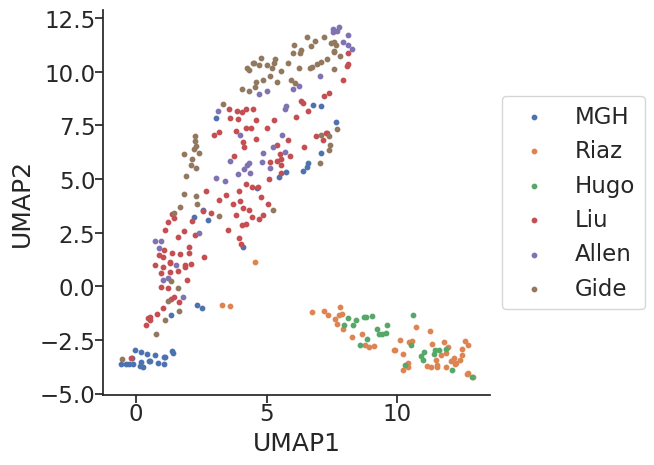

In [4]:
plot_batch(dfp1,  batch_col='cohort')

<Axes: xlabel='CD3E', ylabel='CMKLR1'>

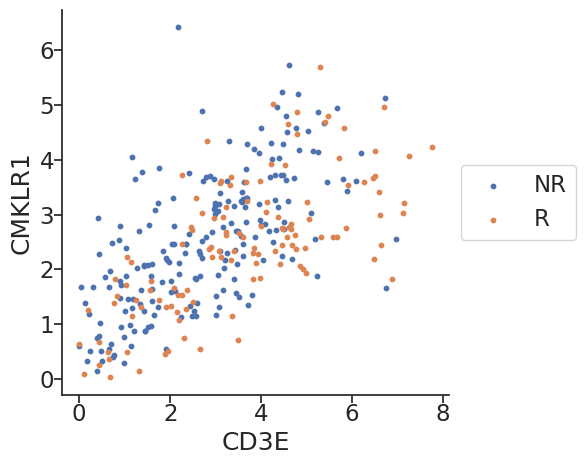

In [5]:
plot_batch(dfp1[['CD3E','CMKLR1']].join(itrp_patient.RECIST_Response),  batch_col='RECIST_Response')

<Axes: xlabel='PIK3CD', ylabel='TOLLIP'>

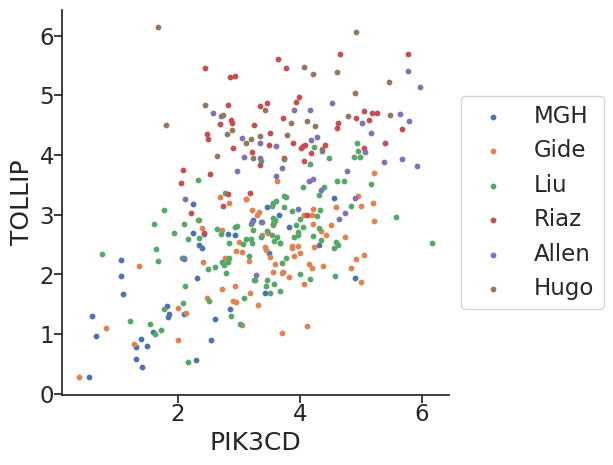

In [6]:
plot_batch(dfp1[BEST].join(itrp_patient.cohort),  batch_col='cohort')

In [7]:
pc = pairwise_combination(combination_pairs = [], n_cpus=8, method='subtraction')
pc = pc.fit(itrp_tpm)

In [8]:
itrp_tpm_cmb = pc.transform()
itrp_tpm_cmb_inverse = pc.inverse(itrp_tpm_cmb)

100%|##########| 269745/269745 [00:54<00:00, 4969.96it/s]


In [ ]:
y_col = 'Freeman_response'
dfxy = itrp_tpm_cmb.join(itrp_tpm_cmb_inverse).join(itrp_patient[[y_col, 'cohort']])

scores = []
for cohort in dfxy.cohort.unique():
    dfxy_c = dfxy[dfxy.cohort == cohort]
    dfxy_c = dfxy_c[dfxy_c.columns[:-1]]
    mic = Xy_score(dfxy_c, y_col, method='mic', n_jobs=6)
    prc = Xy_score(dfxy_c, y_col, method='prc', n_jobs=6)
    roc = Xy_score(dfxy_c, y_col, method='roc', n_jobs=6)
    score = mic.join(prc).join(roc)
    score['mean'] = score.mean(axis=1)
    score = score.sort_values('roc')
    score['cohort'] = cohort
    scores.append(score)

In [100]:
df = pd.concat(scores)
roc = df.roc.reset_index().groupby('gene_name').mean().sort_values('roc')
prc = df.prc.reset_index().groupby('gene_name').mean().sort_values('prc')
mic = df.mic.reset_index().groupby('gene_name').mean().sort_values('mic')

In [103]:
score = mic.join(prc).join(roc)
score['mean'] = score[['prc', 'roc']].mean(axis=1)
score = score.sort_values('mean',ascending=False)

In [106]:
score.head(50)

,mic,prc,roc,mean
gene_name,,,,
TIGIT - ATG12,0.078063,0.627071,0.671157,0.649114
SLAMF6 - ATG12,0.054036,0.630672,0.667239,0.648955
SLAMF7 - ATG12,0.095479,0.610292,0.685487,0.647889
SLAMF7 - RIPK2,0.049970,0.619450,0.670700,0.645075
CD3G - FAS,0.035041,0.618749,0.671284,0.645017
SLAMF7 - IL10,0.053295,0.624713,0.664109,0.644411
STAT4 - ATG12,0.054090,0.632244,0.656086,0.644165
CD6 - ATG12,0.067039,0.624926,0.660315,0.642620
CLEC4C - SERPINB2,0.029642,0.597048,0.687858,0.642453



100%|##########| 1/1 [00:00<00:00, 511.38it/s]

100%|##########| 1/1 [00:00<00:00, 582.46it/s]

100%|##########| 1/1 [00:00<00:00, 556.20it/s]

100%|##########| 1/1 [00:00<00:00, 625.46it/s]

100%|##########| 1/1 [00:00<00:00, 678.14it/s]

100%|##########| 1/1 [00:00<00:00, 718.82it/s]

100%|##########| 1/1 [00:00<00:00, 802.43it/s]

100%|##########| 1/1 [00:00<00:00, 978.15it/s]

100%|##########| 1/1 [00:00<00:00, 940.22it/s]

100%|##########| 1/1 [00:00<00:00, 992.50it/s]

100%|##########| 1/1 [00:00<00:00, 1046.48it/s]

100%|##########| 1/1 [00:00<00:00, 1001.51it/s]


,,roc,prc
cohort,gene_name,,
Allen,SLAMF7 - ATG12,0.751479,0.572377
Gide,SLAMF7 - ATG12,0.764895,0.871206
Hugo,SLAMF7 - ATG12,0.595238,0.628437
Liu,SLAMF7 - ATG12,0.621951,0.553792
MGH,SLAMF7 - ATG12,0.696429,0.690759
Riaz,SLAMF7 - ATG12,0.682927,0.345180


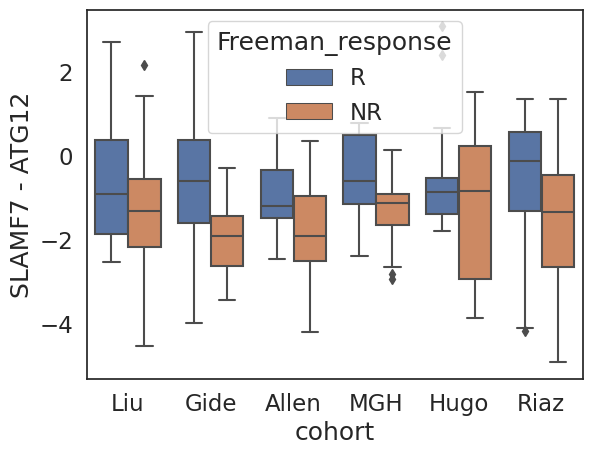

In [107]:
yc = 'SLAMF7 - ATG12'
dfxy = itrp_tpm_cmb.join(itrp_tpm_cmb_inverse).join(itrp_patient[[y_col]])
dfpp = dfxy.join(itrp_patient.cohort)[[yc, 'cohort', y_col]]
sns.boxplot(dfpp,y = yc, x = 'cohort', hue = y_col)

roc = dfpp.groupby('cohort').apply(lambda dfxy:Xy_score(dfxy[[yc, 'Freeman_response']], y_col, method='roc', n_jobs=6))
prc = dfpp.groupby('cohort').apply(lambda dfxy:Xy_score(dfxy[[yc, 'Freeman_response']], y_col, method='prc', n_jobs=6))
roc.join(prc)

In [11]:
dfxy1 = itrp_tpm.join(itrp_patient[y_col])
mic1 = Xy_score(dfxy1, y_col, method='mic', n_jobs=6)
prc1 = Xy_score(dfxy1, y_col, method='prc', n_jobs=6)
roc1 = Xy_score(dfxy1, y_col, method='roc', n_jobs=6)

100%|##########| 735/735 [00:00<00:00, 4518.24it/s]


In [12]:
score1 = mic1.join(prc1).join(roc1)
score1['mean'] = score1.mean(axis=1)
score1 = score1.sort_values('roc')

In [13]:
score1.tail(10)

,mic,prc,roc,mean
gene_name,,,,
IL21,0.057129,0.572189,0.620767,0.416695
NCR1,0.030978,0.571760,0.620878,0.407872
PRF1,0.022237,0.541952,0.622098,0.395429
ITK,0.000000,0.560958,0.622098,0.394352
CD96,0.000000,0.562583,0.622449,0.395011
IL7R,0.066789,0.565036,0.627588,0.419804
LILRA4,0.037552,0.561523,0.629640,0.409572
CD3G,0.099655,0.584466,0.630213,0.438111
CD3D,0.056716,0.592053,0.631359,0.426709


In [14]:
score.tail(10)

,mic,prc,roc,mean
gene_name,,,,
CD3E - IL18,0.048486,0.632331,0.684783,0.455200
PRF1 - F2RL1,0.059242,0.594462,0.684857,0.446187
CD3E - CMKLR1,0.112912,0.645925,0.686816,0.481884
LILRA4 - SERPINB2,0.060801,0.611244,0.687555,0.453200
ICOS - F2RL1,0.056790,0.605689,0.689034,0.450504
PRF1 - CMKLR1,0.045381,0.583941,0.689959,0.439760
LILRB1 - CMKLR1,0.089531,0.634156,0.692787,0.472158
CLEC4C - SERPINB2,0.097508,0.589679,0.693471,0.460219
CCR4 - F2RL1,0.055204,0.648428,0.698721,0.467451


100%|##########| 1/1 [00:00<00:00, 1053.05it/s]


,,roc,prc
cohort,gene_name,,
Allen,CD3E - CMKLR1,0.689349,0.563819
Gide,CD3E - CMKLR1,0.767311,0.830489
Hugo,CD3E - CMKLR1,0.678571,0.704593
Liu,CD3E - CMKLR1,0.544715,0.461745
MGH,CD3E - CMKLR1,0.648810,0.569451
Riaz,CD3E - CMKLR1,0.612195,0.330802


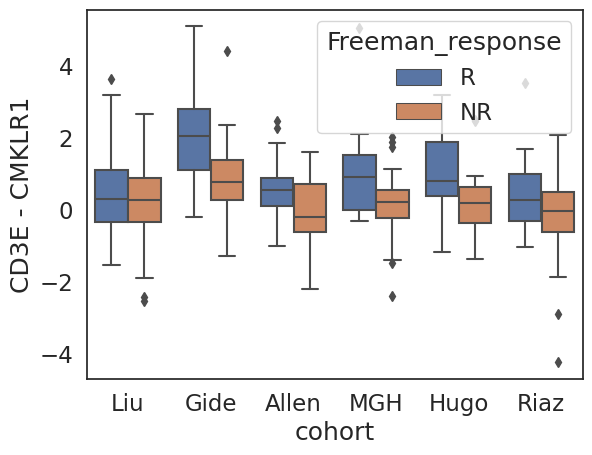

In [53]:
yc = 'CD3E - CMKLR1'
dfpp = dfxy.join(itrp_patient.cohort)[[yc, 'cohort', y_col]]
sns.boxplot(dfpp, y = yc, x = 'cohort', hue = y_col)

roc = dfpp.groupby('cohort').apply(lambda dfxy:Xy_score(dfxy[[yc, 'Freeman_response']], y_col, method='roc', n_jobs=6))
prc = dfpp.groupby('cohort').apply(lambda dfxy:Xy_score(dfxy[[yc, 'Freeman_response']], y_col, method='prc', n_jobs=6))
roc.join(prc)

ValueError: columns overlap but no suffix specified: Index(['cohort'], dtype='object')

100%|##########| 1/1 [00:00<00:00, 1054.64it/s]


,,roc,prc
cohort,gene_name,,
Allen,LILRB1 - CMKLR1,0.710059,0.495619
Gide,LILRB1 - CMKLR1,0.669887,0.778645
Hugo,LILRB1 - CMKLR1,0.666667,0.695656
Liu,LILRB1 - CMKLR1,0.584627,0.490065
MGH,LILRB1 - CMKLR1,0.788690,0.771324
Riaz,LILRB1 - CMKLR1,0.575610,0.311537


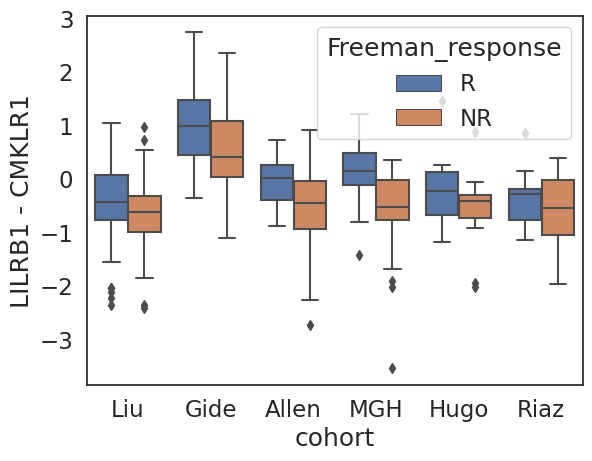

In [54]:
yc = 'LILRB1 - CMKLR1'
dfpp = dfxy.join(itrp_patient.cohort)[[yc, 'cohort', y_col]]
sns.boxplot(dfpp,y = yc, x = 'cohort', hue = y_col)

roc = dfpp.groupby('cohort').apply(lambda dfxy:Xy_score(dfxy[[yc, 'Freeman_response']], y_col, method='roc', n_jobs=6))
prc = dfpp.groupby('cohort').apply(lambda dfxy:Xy_score(dfxy[[yc, 'Freeman_response']], y_col, method='prc', n_jobs=6))
roc.join(prc)

100%|##########| 1/1 [00:00<00:00, 1191.56it/s]


,,roc,prc
cohort,gene_name,,
Allen,PDCD1,0.630178,0.396548
Gide,PDCD1,0.726248,0.812678
Hugo,PDCD1,0.523810,0.508611
Liu,PDCD1,0.490207,0.420075
MGH,PDCD1,0.482143,0.452914
Riaz,PDCD1,0.652439,0.399941


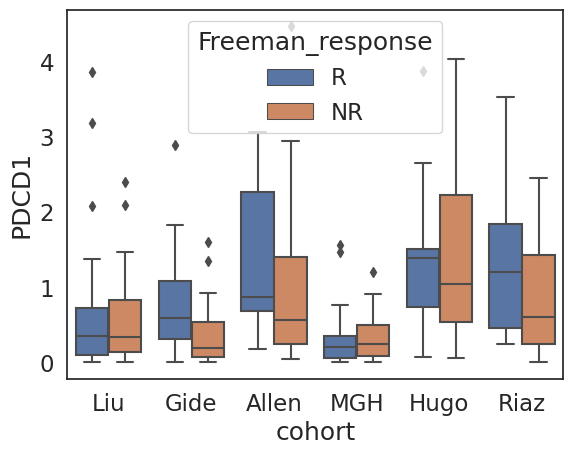

In [55]:
yc = 'PDCD1'
dfpp = dfxy1.join(itrp_patient.cohort)[[yc, 'cohort', y_col]]
sns.boxplot(dfpp,y = yc, x = 'cohort', hue = y_col)

roc = dfpp.groupby('cohort').apply(lambda dfxy:Xy_score(dfxy[[yc, 'Freeman_response']], y_col, method='roc', n_jobs=6))
prc = dfpp.groupby('cohort').apply(lambda dfxy:Xy_score(dfxy[[yc, 'Freeman_response']], y_col, method='prc', n_jobs=6))
roc.join(prc)

100%|##########| 1/1 [00:00<00:00, 1018.03it/s]


,,roc,prc
cohort,gene_name,,
Allen,CD274,0.529586,0.366920
Gide,CD274,0.762882,0.865648
Hugo,CD274,0.595238,0.575677
Liu,CD274,0.526608,0.401311
MGH,CD274,0.507440,0.415448
Riaz,CD274,0.487805,0.192718


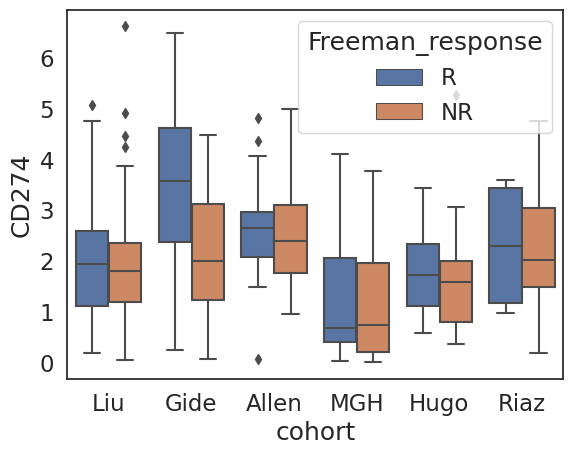

In [56]:
yc = 'CD274'
dfpp = dfxy1.join(itrp_patient.cohort)[[yc, 'cohort', y_col]]
sns.boxplot(dfpp,y = yc, x = 'cohort', hue = y_col)

roc = dfpp.groupby('cohort').apply(lambda dfxy:Xy_score(dfxy[[yc, 'Freeman_response']], y_col, method='roc', n_jobs=6))
prc = dfpp.groupby('cohort').apply(lambda dfxy:Xy_score(dfxy[[yc, 'Freeman_response']], y_col, method='prc', n_jobs=6))
roc.join(prc)

100%|##########| 1/1 [00:00<00:00, 1126.90it/s]


,,roc,prc
cohort,gene_name,,
Allen,CD3E,0.701183,0.469628
Gide,CD3E,0.737520,0.823446
Hugo,CD3E,0.482143,0.538768
Liu,CD3E,0.549889,0.461392
MGH,CD3E,0.502976,0.496148
Riaz,CD3E,0.679268,0.486978


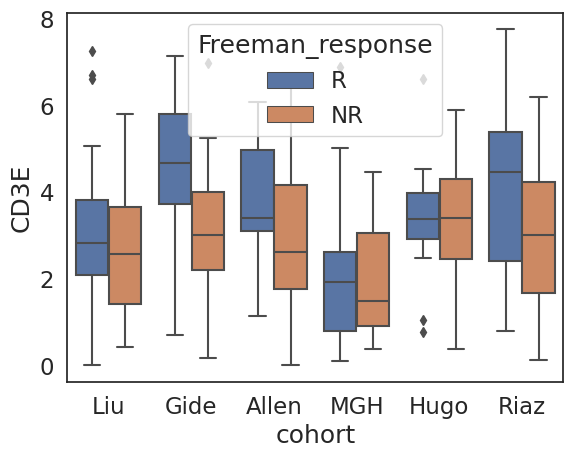

In [57]:
yc = 'CD3E'
dfpp = dfxy1.join(itrp_patient.cohort)[[yc, 'cohort', y_col]]
sns.boxplot(dfpp,y = yc, x = 'cohort', hue = y_col)

roc = dfpp.groupby('cohort').apply(lambda dfxy:Xy_score(dfxy[[yc, 'Freeman_response']], y_col, method='roc', n_jobs=6))
prc = dfpp.groupby('cohort').apply(lambda dfxy:Xy_score(dfxy[[yc, 'Freeman_response']], y_col, method='prc', n_jobs=6))
roc.join(prc)

100%|##########| 1/1 [00:00<00:00, 1086.33it/s]


,,roc,prc
cohort,gene_name,,
Allen,CD3E - CMKLR1,0.689349,0.563819
Gide,CD3E - CMKLR1,0.767311,0.830489
Hugo,CD3E - CMKLR1,0.678571,0.704593
Liu,CD3E - CMKLR1,0.544715,0.461745
MGH,CD3E - CMKLR1,0.648810,0.569451
Riaz,CD3E - CMKLR1,0.612195,0.330802


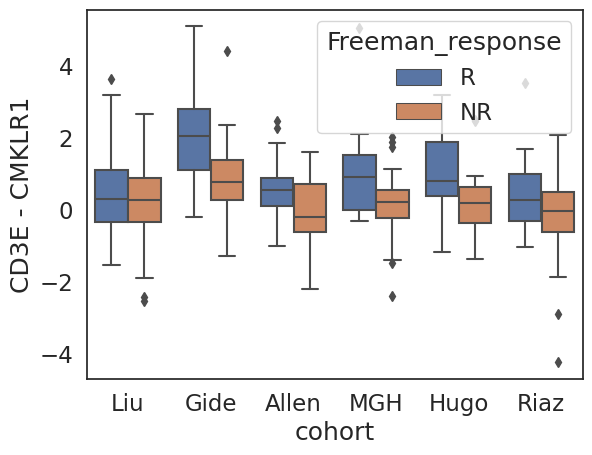

In [58]:
yc = 'CD3E - CMKLR1'
dfpp = dfxy.join(itrp_patient.cohort)[[yc, 'cohort', y_col]]
sns.boxplot(dfpp,y = yc, x = 'cohort', hue = y_col)

roc = dfpp.groupby('cohort').apply(lambda dfxy:Xy_score(dfxy[[yc, 'Freeman_response']], y_col, method='roc', n_jobs=6))
prc = dfpp.groupby('cohort').apply(lambda dfxy:Xy_score(dfxy[[yc, 'Freeman_response']], y_col, method='prc', n_jobs=6))
roc.join(prc)

In [59]:
roc.join(prc).mean()

roc    0.656825
prc    0.576816
dtype: float64

100%|##########| 1/1 [00:00<00:00, 1356.50it/s]


,,roc,prc
cohort,gene_name,,
Allen,CCR4 - F2RL1,0.677515,0.482568
Gide,CCR4 - F2RL1,0.789855,0.837197
Hugo,CCR4 - F2RL1,0.392857,0.505950
Liu,CCR4 - F2RL1,0.680710,0.552557
MGH,CCR4 - F2RL1,0.571429,0.478578
Riaz,CCR4 - F2RL1,0.665854,0.507535


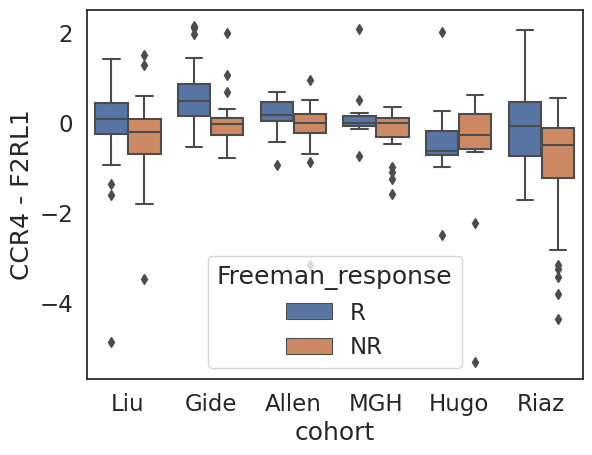

In [49]:
yc = 'CCR4 - F2RL1'
dfpp = dfxy.join(itrp_patient.cohort)[[yc, 'cohort', y_col]]
sns.boxplot(dfpp,y = yc, x = 'cohort', hue = y_col)

roc = dfpp.groupby('cohort').apply(lambda dfxy:Xy_score(dfxy[[yc, 'Freeman_response']], y_col, method='roc', n_jobs=6))
prc = dfpp.groupby('cohort').apply(lambda dfxy:Xy_score(dfxy[[yc, 'Freeman_response']], y_col, method='prc', n_jobs=6))
roc.join(prc)

100%|##########| 1/1 [00:00<00:00, 1066.17it/s]


,,roc,prc
cohort,gene_name,,
Allen,PIK3CD - TOLLIP,0.707101,0.481360
Gide,PIK3CD - TOLLIP,0.739936,0.807271
Hugo,PIK3CD - TOLLIP,0.494048,0.570062
Liu,PIK3CD - TOLLIP,0.686992,0.607913
MGH,PIK3CD - TOLLIP,0.752976,0.635406
Riaz,PIK3CD - TOLLIP,0.721951,0.470477


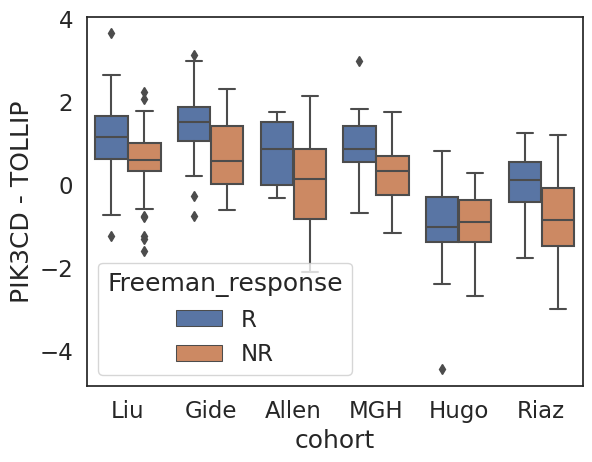

In [60]:
yc = 'PIK3CD - TOLLIP'
dfpp = dfxy.join(itrp_patient.cohort)[[yc, 'cohort', y_col]]
sns.boxplot(dfpp,y = yc, x = 'cohort', hue = y_col)

roc = dfpp.groupby('cohort').apply(lambda dfxy:Xy_score(dfxy[[yc, 'Freeman_response']], y_col, method='roc', n_jobs=6))
prc = dfpp.groupby('cohort').apply(lambda dfxy:Xy_score(dfxy[[yc, 'Freeman_response']], y_col, method='prc', n_jobs=6))
roc.join(prc)

In [23]:
tcga_corr = pairwise_correlation(tcga_tpm.values, method = 'pearson')
df_tcga_corr = pd.DataFrame(tcga_corr, index=tcga_tpm.columns, columns=tcga_tpm.columns)

the number of process is 8


100%|##########| 269745/269745 [00:00<00:00, 2062262.99it/s]


In [24]:
tcga_mir = pairwise_correlation(tcga_tpm.values, method = 'mutual_info')
df_tcga_mir = pd.DataFrame(tcga_mir, index=tcga_tpm.columns, columns=tcga_tpm.columns)

the number of process is 8


100%|##########| 269745/269745 [00:00<00:00, 1225890.29it/s]


In [25]:
df_tcga_corr.to_pickle(os.path.join(data_path, 'TCGA.COR.TABLE'))
df_tcga_mir.to_pickle(os.path.join(data_path, 'TCGA.MIR.TABLE'))

In [26]:
score.loc['CD274 - SERPINB2']

mic     0.034721
prc     0.585818
roc     0.651564
mean    0.424034
Name: CD274 - SERPINB2, dtype: float64

In [27]:
score1.loc['CD274']

mic     0.000000
prc     0.530049
roc     0.591301
mean    0.373783
Name: CD274, dtype: float64

In [28]:
score.loc['PDCD1 - CMKLR1']

mic     0.000000
prc     0.466057
roc     0.575495
mean    0.347184
Name: PDCD1 - CMKLR1, dtype: float64

In [29]:
idx = score.tail(150)
pairs = idx.index.map(lambda x:x.split(' - '))

In [30]:
corr = [df_tcga_corr.loc[p[0]][p[1]] for p in pairs]

In [31]:
idx['corr'] = corr

/tmp/ipykernel_459/595196197.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idx['corr'] = corr


In [32]:
idx['g1'] = idx.index.map(lambda x:x.split(' - ')[0])
idx['g2'] = idx.index.map(lambda x:x.split(' - ')[1])

/tmp/ipykernel_459/3518932279.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idx['g1'] = idx.index.map(lambda x:x.split(' - ')[0])
/tmp/ipykernel_459/3518932279.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idx['g2'] = idx.index.map(lambda x:x.split(' - ')[1])


In [33]:
idx.tail(30).g1.unique()

array(['PRF1', 'CD3E', 'CD247', 'TLR10', 'IL32', 'RUNX3', 'CCR4',
       'PIK3CD', 'NCR1', 'FUT7', 'ICOS', 'CD96', 'FLT3', 'LILRA4',
       'LILRB1', 'CLEC4C'], dtype=object)

In [34]:
idx.tail(30).g2.unique()

array(['CXCL16', 'SERPINB2', 'FEZ1', 'ATG12', 'F2RL1', 'IFITM1', 'TOLLIP',
       'TNFSF13', 'TNFSF12', 'ABL1', 'TLR2', 'IL18', 'CMKLR1'],
      dtype=object)

In [47]:
score2 = score.sort_values('prc', ascending=False)
score1 = score1.sort_values('prc', ascending=False)
score2.to_csv('pair.csv')
score1.to_csv('single.csv')